# SUIM-NET

Hier wurde das SUIM-NET implementiert. Dieses besteht aus 3 Encoder und 3 Decoder Blöcken. Es gibt ähnliche copy Operationen wie im U-Net. Jedoch werden hier keine activationmaps des Encoders direkt an die activationmaps des Decoders angehängt wie beim U-Net. Es wird zuerst ein skiplayer elementweise zu den activationmaps des RSB addiert. Als skip-layer werden entweder direkt der Output vom vorherigen RSB verwendet oder es wird zuerst noch eine Convolution mit Batchnormalization durchgeführt. Dann werden diese activationmaps wieder im decoder benutzt. Die ähnlichkeit der Architektur zum U-Net ist auch in der performance ersichtlich. U-Net erzielt ähnliche Metriken im paper wie das SUIM-NET. 

In [1]:
# import: external libraries
import torch
import torchshow as ts

from torch.utils.data import DataLoader
from torch import nn

print(f"cuda: {torch.cuda.is_available()}")

# import: own modules
from underwater_imagery.models.suim_net.suim_net import SuimNet
from underwater_imagery.data.uim_dataset import UIMDataset
from underwater_imagery.data.constants import TRAIN_PATH, TEST_PATH, CLASSES, SHAPE
from underwater_imagery.data.transf import resize_transf, resize_normalize_transf
from underwater_imagery.models.iou_loss import SoftIoULoss
from underwater_imagery.models.metrics import logits_to_idx_class, eval
from underwater_imagery.data.transf import pred_to_label
from underwater_imagery.models.train_model import train_model

cuda: True


In [2]:
batch_size = 8

In [8]:
ds = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_normalize_transf,
    resize_transf
)

ds_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

In [3]:
# train the model
torch.manual_seed(123)

# Parameters
num_epochs = 5
suim_path = f"suim_net_epoch{num_epochs}"
device = 'cuda'

# create model
suim_net = SuimNet(
    classes=CLASSES,
    device=device
)

# Create Loss-Function
criterion = nn.CrossEntropyLoss()
iou_loss = SoftIoULoss()

_ = train_model(
   model=suim_net,
   loss_module=criterion,
   ds_loader=ds_loader,
   num_epochs=num_epochs,
   file_name=suim_path
)


  0%|          | 0/955 [00:00<?, ?it/s]

SuimNet(
  (encoder): SuimEncoder(
    (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (maxpool_2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (rsb_2_1): RSB(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
      (conv_skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (bn_skip): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    )
    (rsb_2_2_1): RSB(
      (

# IoU loss vs cross-entropy loss
Dieselbe Architektur wurde hier mit zwei unterschiedlichen Loss-Funktionen traininert.

In [3]:
# load trained models
suim_iou_120 = torch.load("suim_net_epoch120_iou.pth")
suim_iou_120.eval()

suim_criterion_500 = torch.load("suim_net_epoch500.pth")
suim_criterion_500.eval()
print("models loaded.")

models loaded.


Das Model mit cross-entropy-loss hat schärfere Grenzen und etwas bessere Metriken erzielt. Dies könnte jedoch auch an den zusätzlichen Trainingsiterationen liegen. Aus den Beispiel-Bildern ist ersichtlich, dass das Model jeweils grosse Flächen wie (BW, WR, SR) gut erkennt. Je kleiner die Objekte werden, desto schlechter werden diese erkannt. Eventuell könnte eine Regularisierung helfen, in dem man kleine Flächen stärker belohnt. 

image, image_label, IoU loss, cross entropy loss


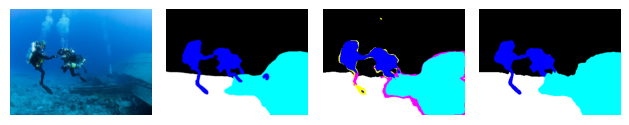

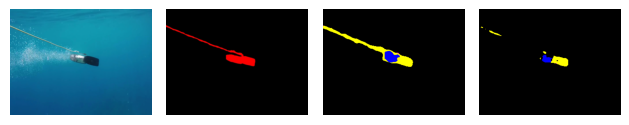

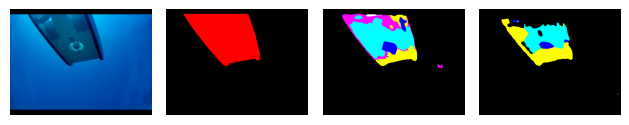

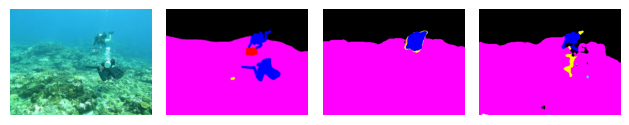

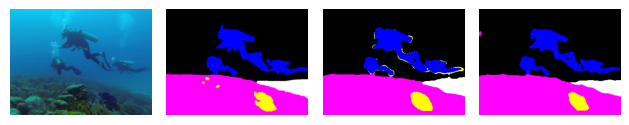

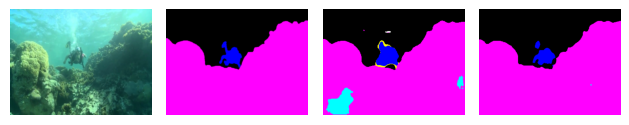

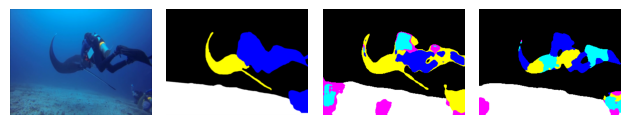

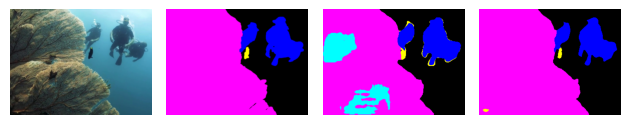

In [8]:
print("image, image_label, IoU loss, cross entropy loss")
for i in range(0, 15, 2):
    images, _, label_images = ds[i]
    images_gpu = images.unsqueeze(0).to('cuda')
    logits_iou = suim_iou_120(images_gpu)
    pred_iou = logits_to_idx_class(logits_iou)
    pred_label_iou = pred_to_label(pred_iou).squeeze(0)
    logits_criterion = suim_criterion_500(images_gpu)
    pred_criterion = logits_to_idx_class(logits_criterion)
    pred_label_criterion = pred_to_label(pred_criterion).squeeze(0)
    ts.show([images, label_images, pred_label_iou, pred_label_criterion])

In [4]:
ds_test = UIMDataset(
    TEST_PATH, 
    CLASSES, 
    SHAPE, 
    resize_normalize_transf, 
    resize_transf
)

ds_test_loader = DataLoader(
    ds_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8    
)

Die Confusionmatrix ist hier Prozentual dargestellt. Da die Zahlen mit einzelnen Pixeln zu gross/ schlecht vergleichbar wären.

IoU loss, 120 epochs, train.


always micro
precision: 0.829
recall: 0.829
f1 score: 0.829
mean pixel acc: 0.829
soft log IoU loss: 2.789
cross entropy loss: 1.160


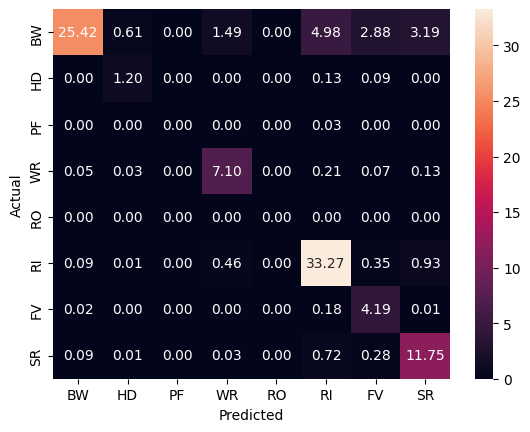

In [9]:
print("IoU loss, 120 epochs, train.")
eval(suim_iou_120, ds_loader, device=suim_iou_120.device)

IoU loss, 120 epochs, test.
always micro
precision: 0.687
recall: 0.687
f1 score: 0.687
mean pixel acc: 0.687
soft log IoU loss: 2.832
cross entropy loss: 1.398


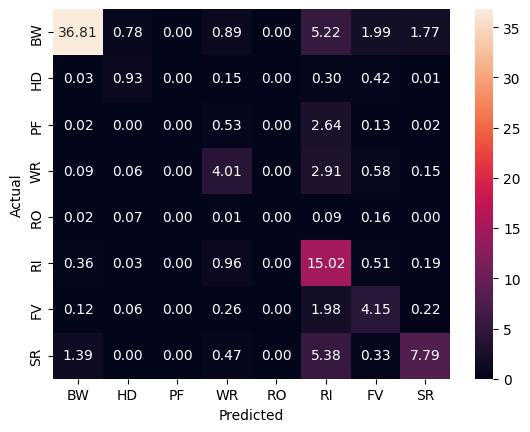

In [5]:
print("IoU loss, 120 epochs, test.")
eval(suim_iou_120, ds_test_loader, device=suim_iou_120.device, max_iter=110)

cross entropy loss, 500 epochs
always micro
precision: 0.866
recall: 0.866
f1 score: 0.866
mean pixel acc: 0.866
soft log IoU loss: 2.757
cross entropy loss: 1.158


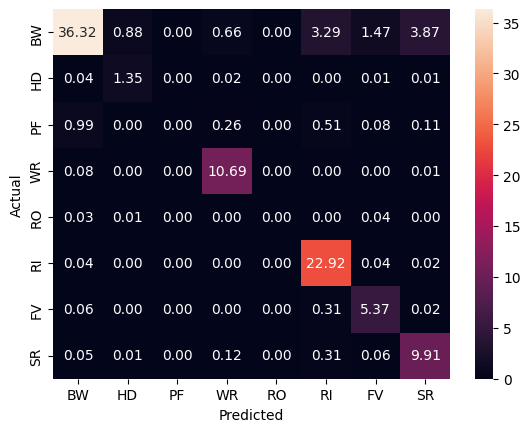

In [10]:
print("cross entropy loss, 500 epochs, train.")
eval(suim_criterion_500, ds_loader, device=suim_criterion_500.device)

cross entropy loss, 500 epochs, test
always micro
precision: 0.715
recall: 0.715
f1 score: 0.715
mean pixel acc: 0.715
soft log IoU loss: 2.828
cross entropy loss: 1.385


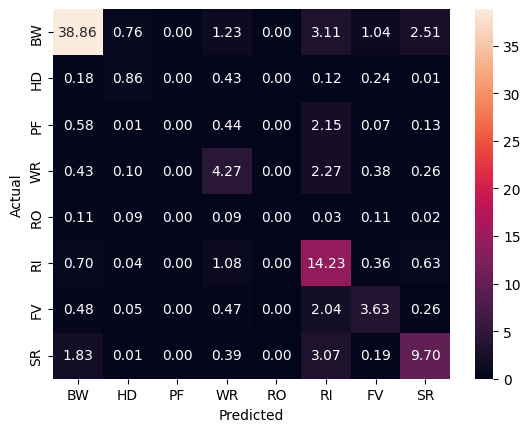

In [5]:
print("cross entropy loss, 500 epochs, test")
eval(suim_criterion_500, ds_test_loader, device=suim_criterion_500.device, max_iter=110)

# Diskussion
# SUIM-Net untereinander
Beide Modelle weisen einen deutlichen Unterschied zwischen dem Trainingscore und dem Testscore (schlechter) auf. Dies könnte auf ein Overfitting hinweisen. Ausserdem werden vorallem auf dem Testset Reefs and invertebrates mit anderen Klassen verwechselt. Dies könnte daran liegen, dass diese Klasse ähnliche Siluetthen wie andere annehmen kann. 

# SUIM-Net gegen Model ohne copy/skip operationen
SUIM-NET Modelle scheiden besser ab, wie die eigen Architektur, welche keine skip/copy operationen beinhaltet. 